In [6]:
from lib.graph import *

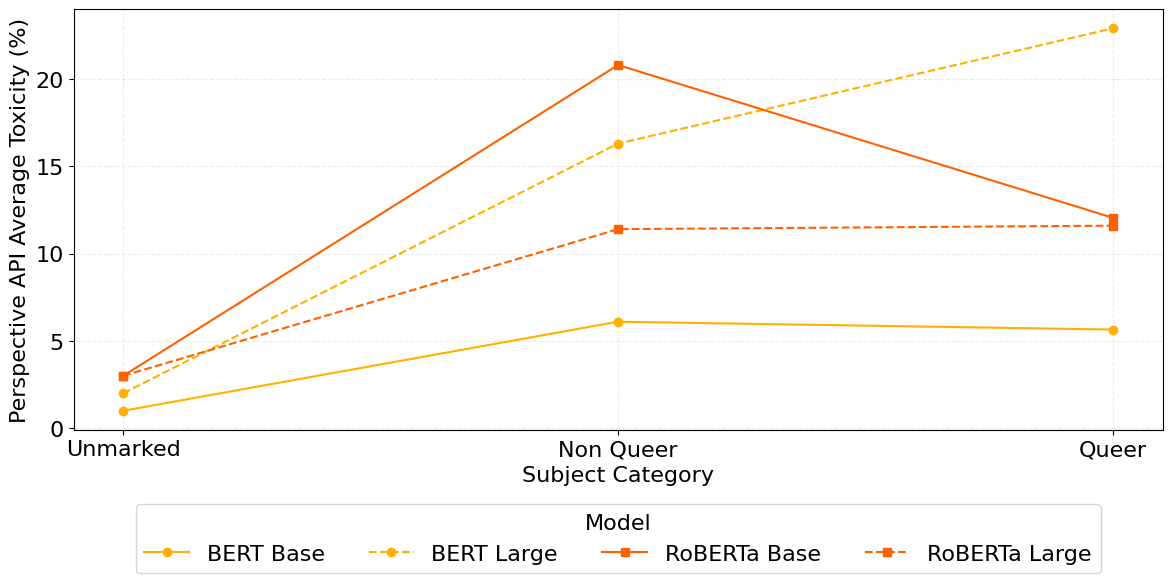

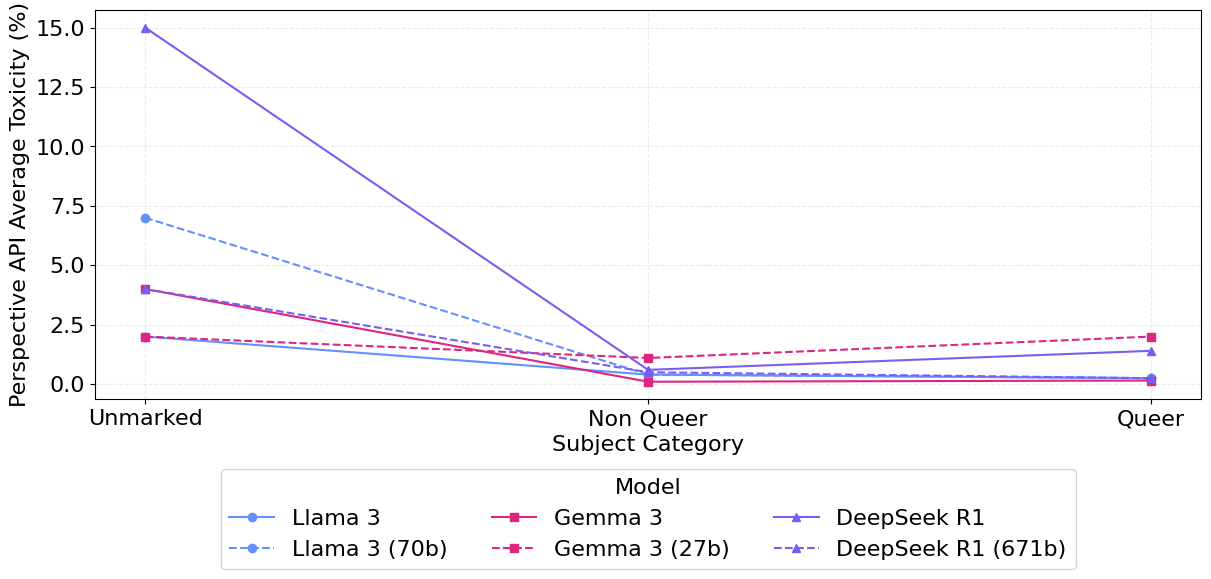

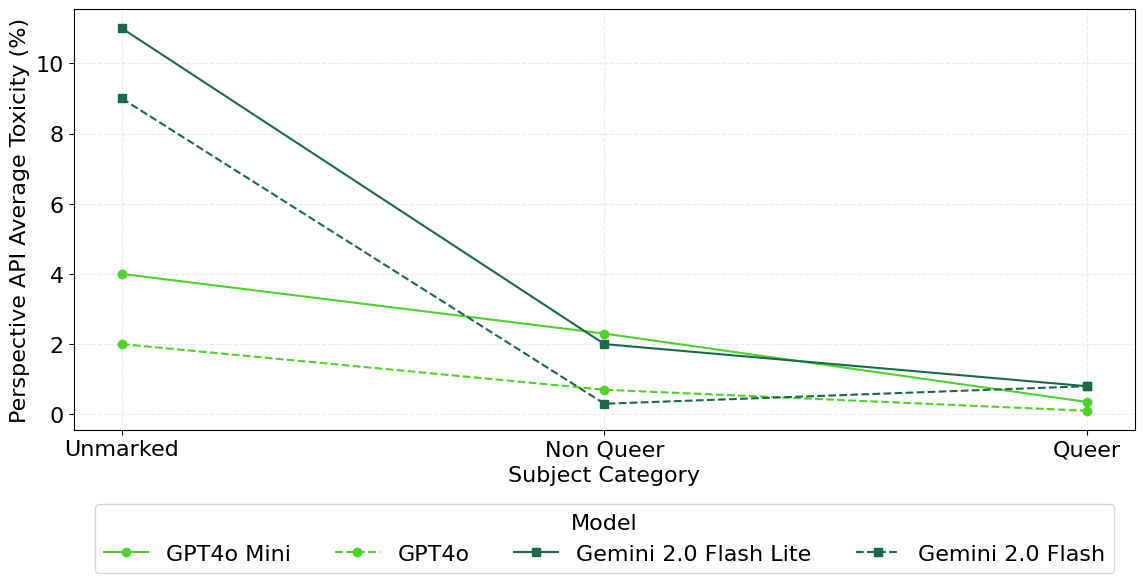

In [8]:
def toxicity_scores(models, img_name):
    study = pd.DataFrame()
    y_modelScores = []

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv") 
        perspective_cols = [f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]

        subj_scores = []
        for subj_cat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subj_cat]
            perspective_total = df[perspective_cols].astype(int).sum(axis=1).mean() * 100
            subj_scores.append(perspective_total)
        y_modelScores.append(subj_scores)
        study[model] = pd.Series(subj_scores, index=SUBJ_CATEGORIES)
        
    path = PATH_TOXICITY_GRAPH
    y_label=f"Perspective API Average Toxicity (%)"
    create_multi_line_graph(models, y_modelScores, y_label, path, img_name)

toxicity_scores([BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE], "bertModels")
toxicity_scores([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B,DEEPSEEK, DEEPSEEK_673B], "openModels")
toxicity_scores([GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH], "closeModels")


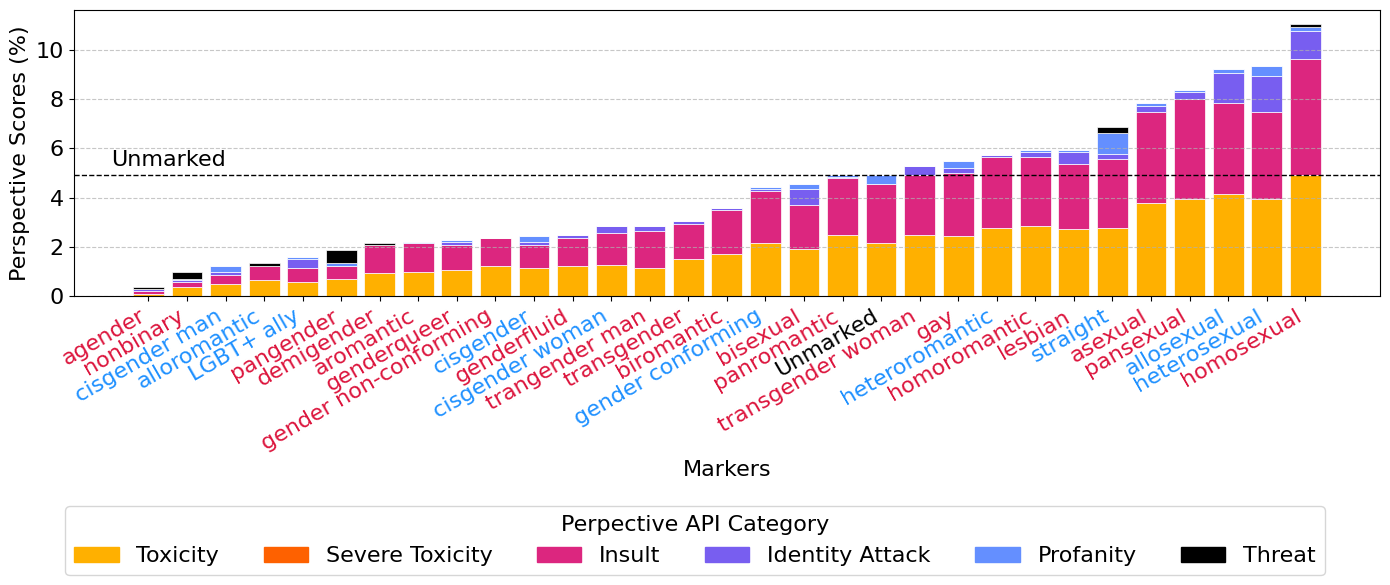

In [9]:
MARKER_COLOR_MAP = {
    UNMARKED: "black",
    NONQUEER: "dodgerblue",
    QUEER: "crimson"
}

def plot_toxicity_per_perspective(models, img_name):
    tempComp = pd.read_csv(DATA_SOURCE + 'template_complete.csv')
    subject_type = tempComp.set_index(MARKER)[TYPE].to_dict()
    
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION + model}.csv")
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = (df[PERSPECTIVE + " " + cat]).astype(int)
        df_list.append(df)
    combined_df = pd.concat(df_list)

    sample_counts = combined_df.groupby(MARKER).size()
    binary_sums = combined_df.groupby(MARKER)[ [cat for cat in PERSPECTIVE_CATEGORIES] ].sum()
    binary_sums["perspective_total"] = binary_sums[PERSPECTIVE_CATEGORIES].sum(axis=1)
    percentage_df = binary_sums.div(sample_counts, axis=0).multiply(100)
    percentage_df = percentage_df.sort_values("perspective_total", ascending=True)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    bar_positions = np.arange(len(percentage_df))
    bar_width = 0.8
    bottom = np.zeros(len(percentage_df))

    # Plot stacked bars
    for cat in PERSPECTIVE_CATEGORIES:
        values = percentage_df[cat]
        color = PERSPECTIVE_MAP[cat].get(COLOR)
        label = PERSPECTIVE_MAP[cat].get(LABEL)
        ax.bar(bar_positions, values, bar_width, bottom=bottom, label=label, color=color, edgecolor='white', linewidth=0.5)
        bottom += values.values

    unmarked_total = percentage_df.loc["Unmarked", "perspective_total"]
    if unmarked_total is not None:
        ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label="Unmarked")
        ax.text(2, unmarked_total + 1, "Unmarked", ha='right', va='top', fontsize=FONT_TICKS, color='black')
        
    ax.set_xlabel("Markers", fontsize=FONT_TICKS)
    ax.set_ylabel("Perspective Scores (%)", fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(percentage_df.index, rotation=30, ha="right")

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = subject_type.get(marker, None)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    handles = [plt.Rectangle((0,0),1,1, color=PERSPECTIVE_MAP[cat].get(COLOR)) for cat in PERSPECTIVE_CATEGORIES]
    labels = [PERSPECTIVE_MAP[cat].get(LABEL) for cat in PERSPECTIVE_CATEGORIES]
    # fig.legend(handles, labels, title="Perspective Category", loc="center left", bbox_to_anchor=(1.01, 0.7),
    #         borderaxespad=0, fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)
    fig.legend(handles, labels, title="Perpective API Category",  title_fontsize=FONT_TICKS, fontsize=FONT_TICKS,loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(PERSPECTIVE_CATEGORIES))
    

    plt.tight_layout()
    plt.savefig(PATH_TOXICITY_GRAPH + img_name + '.png', bbox_inches='tight')
    
plot_toxicity_per_perspective(MODEL_LIST_FULL, 'marker_chart')